# Clustering

## k-means 层次聚类 密度聚类 不同数据集上比较

In [1]:
from os.path import join, basename, splitext
from glob import glob
from warnings import filterwarnings
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import rand, seed
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.datasets import make_blobs, make_circles, make_moons
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns

In [2]:
# 画图显示设置
%matplotlib notebook
seed(42)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
filterwarnings('ignore')
cmap = ListedColormap(sns.color_palette(flatui))
pd.options.display.float_format = '{:,.2f}'.format

<IPython.core.display.Javascript object>


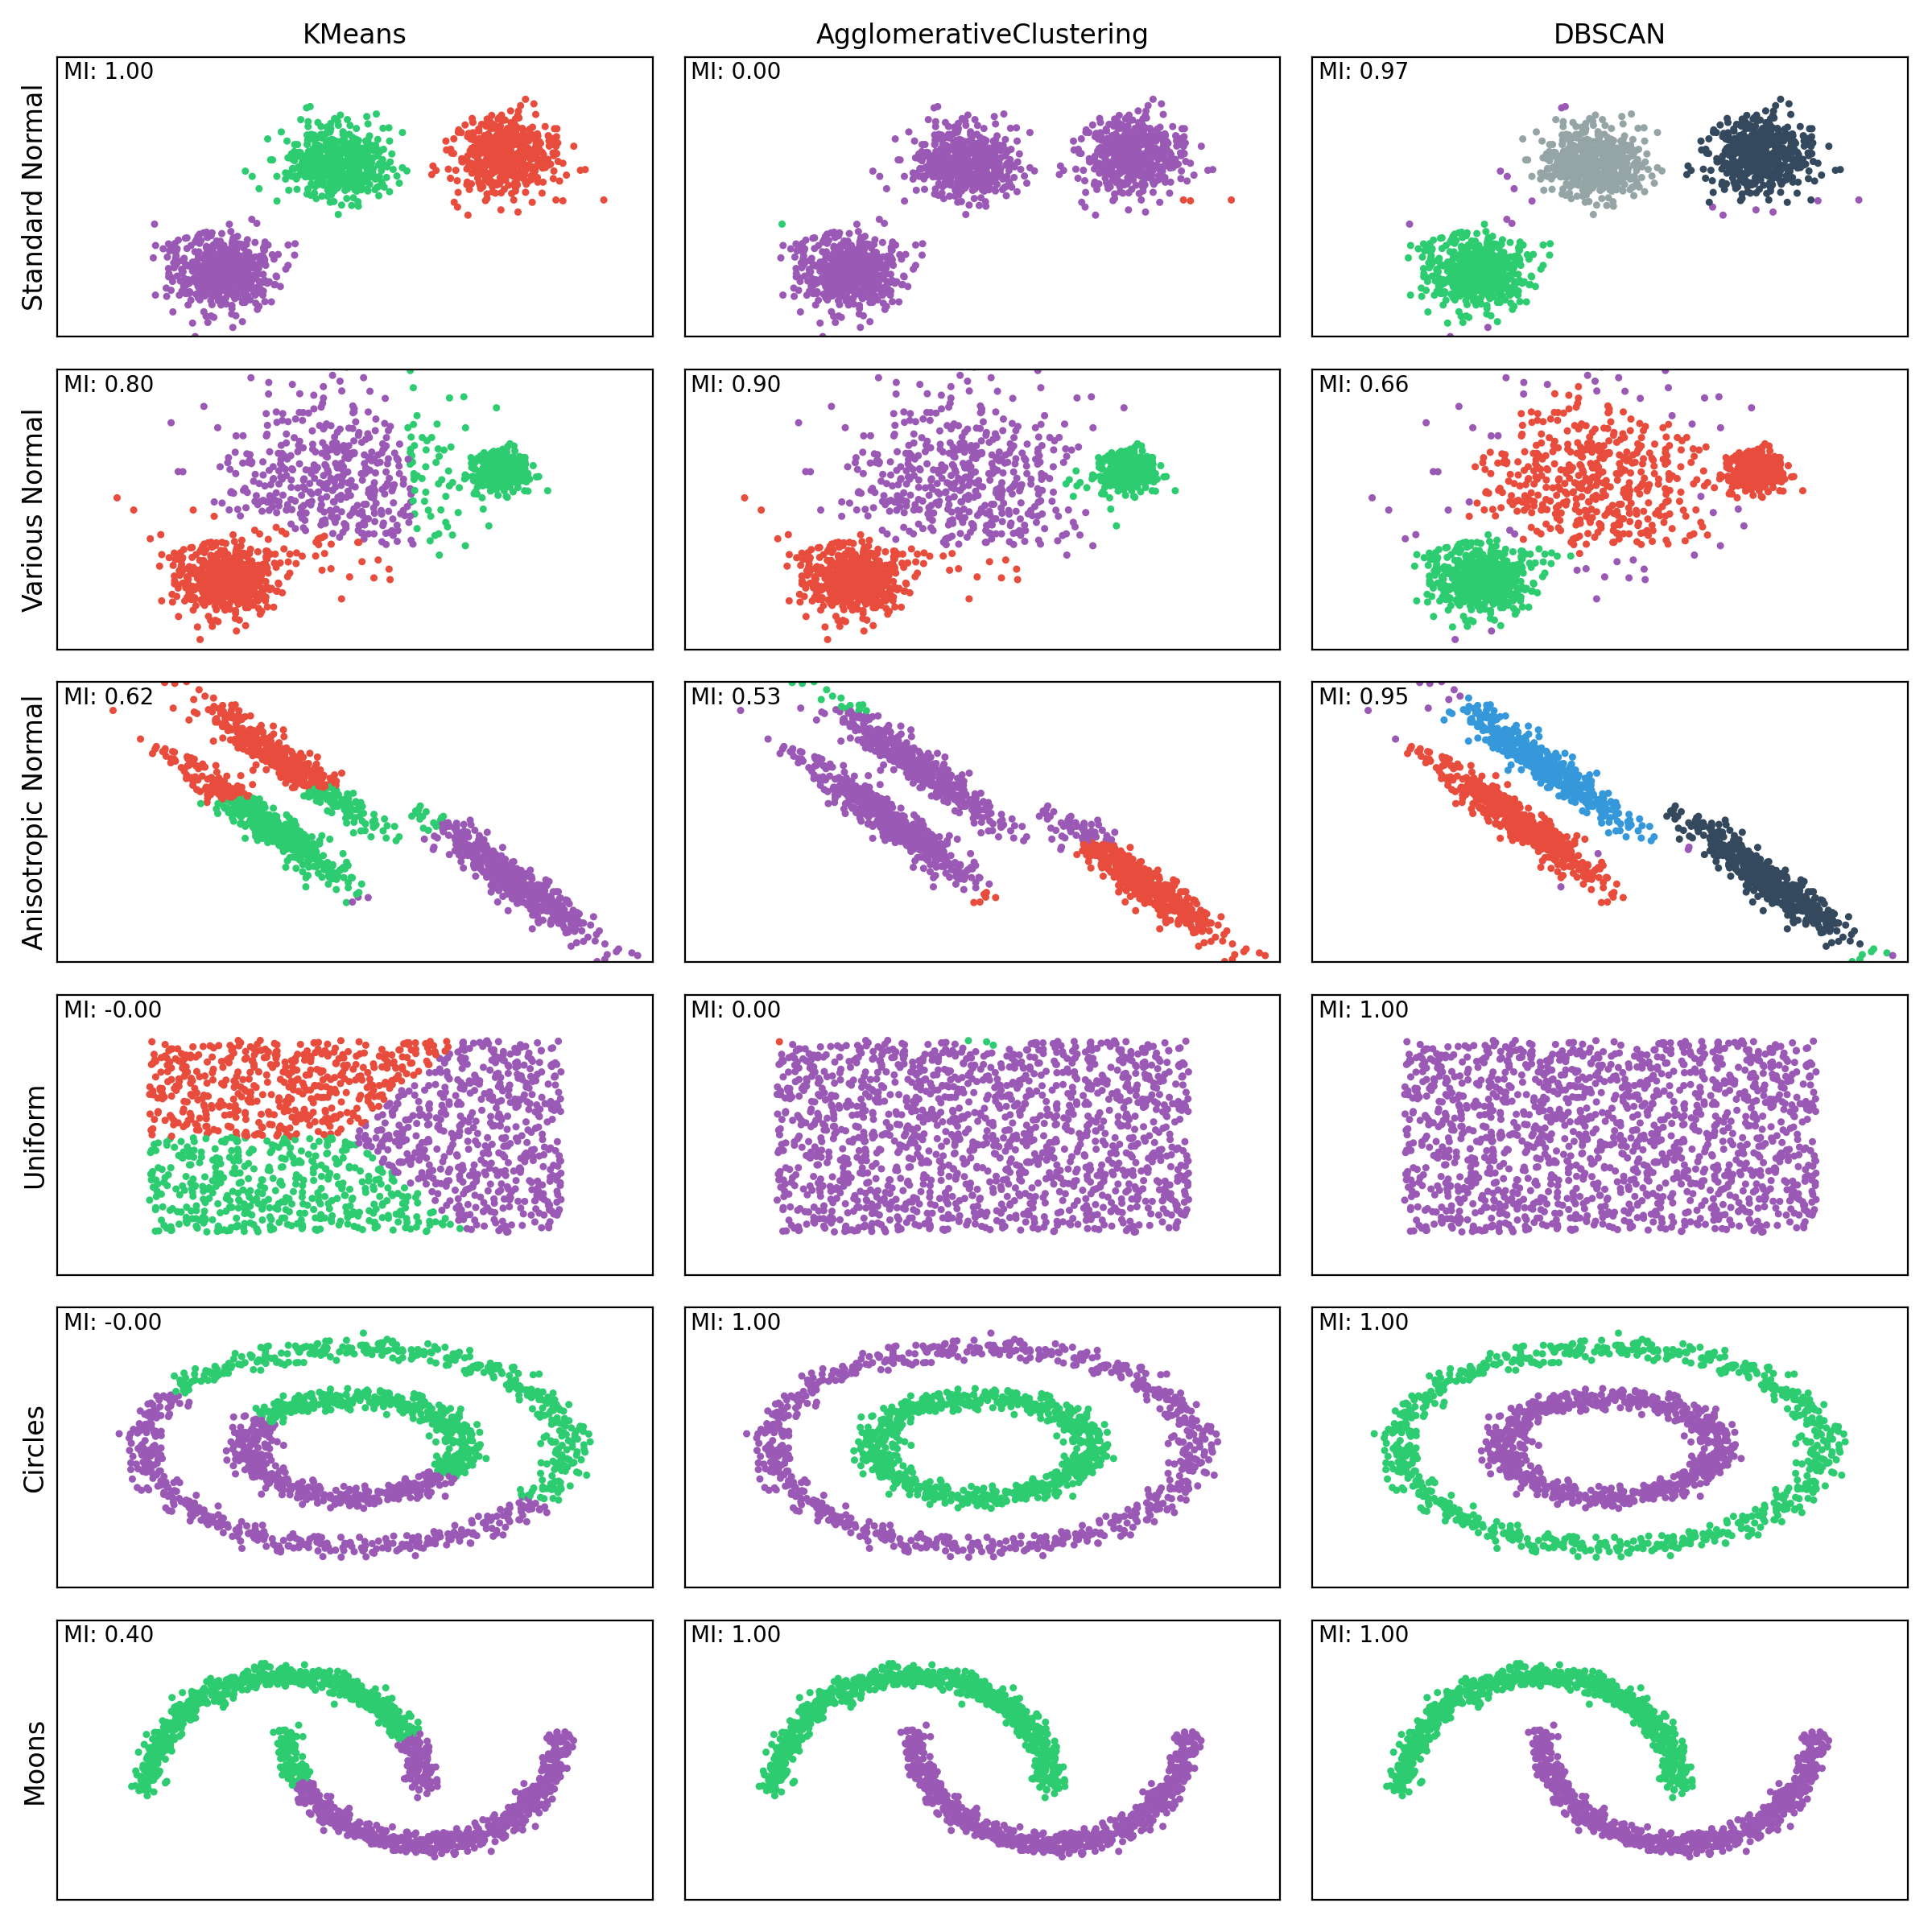

In [3]:
n_samples = 1500
random_state = 170
# 准备了六种常见的数据格式，对比k-means、层次聚类、密度聚类分别在各种分布数据上的表现
# noisy_circles: 数据点围成大小两个同心圈状。
# noisy_moons: 数据点构成两个交错的半圆。
# blobs: 数据点形如团状高斯块。
# varied: 可变方差的数据块。
# aniso: 各向异性分布的数据块。
# Uniform: 均匀分布的数据。
# MI值：adjusted_mutual_info_score，取值范围[0,1]值越大意味着聚类结果与真实情况越吻合。
blobs = make_blobs(n_samples=n_samples, random_state=random_state)
noisy_circles = make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = make_moons(n_samples=n_samples, noise=.05)

uniform = rand(n_samples, 2), None

X, y = make_blobs(n_samples=n_samples, random_state=random_state)
elongated = X.dot([[0.6, -0.6], [-0.4, 0.8]]), y

varied = make_blobs(n_samples=n_samples,
                    cluster_std=[1.0, 2.5, 0.5],
                    random_state=random_state)

# 数据集构造
default_params = {'quantile': .3,
                  'eps': .2,
                  'damping': .9,
                  'preference': -200,
                  'n_neighbors': 10,
                  'n_clusters': 3}

datasets = [('Standard Normal', blobs, {}),
            ('Various Normal', varied, {'eps': .18, 'n_neighbors': 2}),
            ('Anisotropic Normal', elongated, {'eps': .15, 'n_neighbors': 2}),
            ('Uniform', uniform, {}),
            ('Circles', noisy_circles, {'damping': .77, 'preference': -240,
                                        'quantile': .2, 'n_clusters': 2}),
            ('Moons', noisy_moons, {'damping': .75,
                                    'preference': -220, 'n_clusters': 2})
            ]


fig, axes = plt.subplots(figsize=(12, 12), ncols=3,
                         nrows=len(datasets), sharey=True, sharex=True)
plt.setp(axes, xticks=[], yticks=[], xlim=(-2.5, 2.5), ylim=(-2.5, 2.5))

for d, (dataset_label, dataset, algo_params) in enumerate(datasets):
    params = default_params.copy()
    params.update(algo_params)

    X, y = dataset
    X = StandardScaler().fit_transform(X)

    # 层次聚类距离度量方式，离差平方和Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T)

    # 三种聚类模型
    kmeans = KMeans(n_clusters=params['n_clusters'])
    dbscan = DBSCAN(eps=params['eps'])
    average_linkage = AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    
    clustering_algorithms = (
        ('KMeans', kmeans),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan)
    )
    # 绘图
    for a, (name, algorithm) in enumerate(clustering_algorithms):
        y_pred = algorithm.fit_predict(X)

        axes[d, a].scatter(X[:, 0], X[:, 1], s=5, c=y_pred, cmap=cmap)
        if d == 0:
            axes[d, a].set_title(name, size=12)
        if a == 0:
            axes[d, a].set_ylabel(dataset_label, size=12)
        
        if y is None:
            y = [.5] * n_samples
        mi = adjusted_mutual_info_score(labels_pred=y_pred, labels_true=y)
        axes[d, a].text(0.01, 0.92, 'MI: {:.2f}'.format(mi), transform=axes[d, a].transAxes, fontsize=10)

fig.tight_layout()

## 构造数据集

In [4]:
from sklearn.datasets import make_blobs

# make_blobs可构造数据点形如团状高斯块，n_samples：样本数；centers要生成的样本中心数；n_features：每个样本的特征数，2维便于作图；
# cluster_std：指定每个类别的方差，聚合程度不同的数据团；random_state：随机种子，便于复现
x, y = make_blobs(n_samples=100, centers=4, n_features=2, cluster_std=[1, 1.5, 2, 2], random_state=7)

df_blobs = pd.DataFrame(
    {
        'x1': x[:,0],
        'x2': x[:,1],
        'y': y
    }
)

In [5]:
def plot_2d_clusters(x, y, ax):
    
    y_uniques = pd.Series(y).unique()
    
    for y_unique_item in y_uniques:
        x[
            y == y_unique_item
        ].plot(
            title=f'{len(y_uniques)} Clusters',
            kind='scatter',
            x='x1',
            y='x2',
            marker=f'${y_unique_item}$',
            s=60,
            color='k',
            ax=ax,
            alpha=0.7
        )

<IPython.core.display.Javascript object>


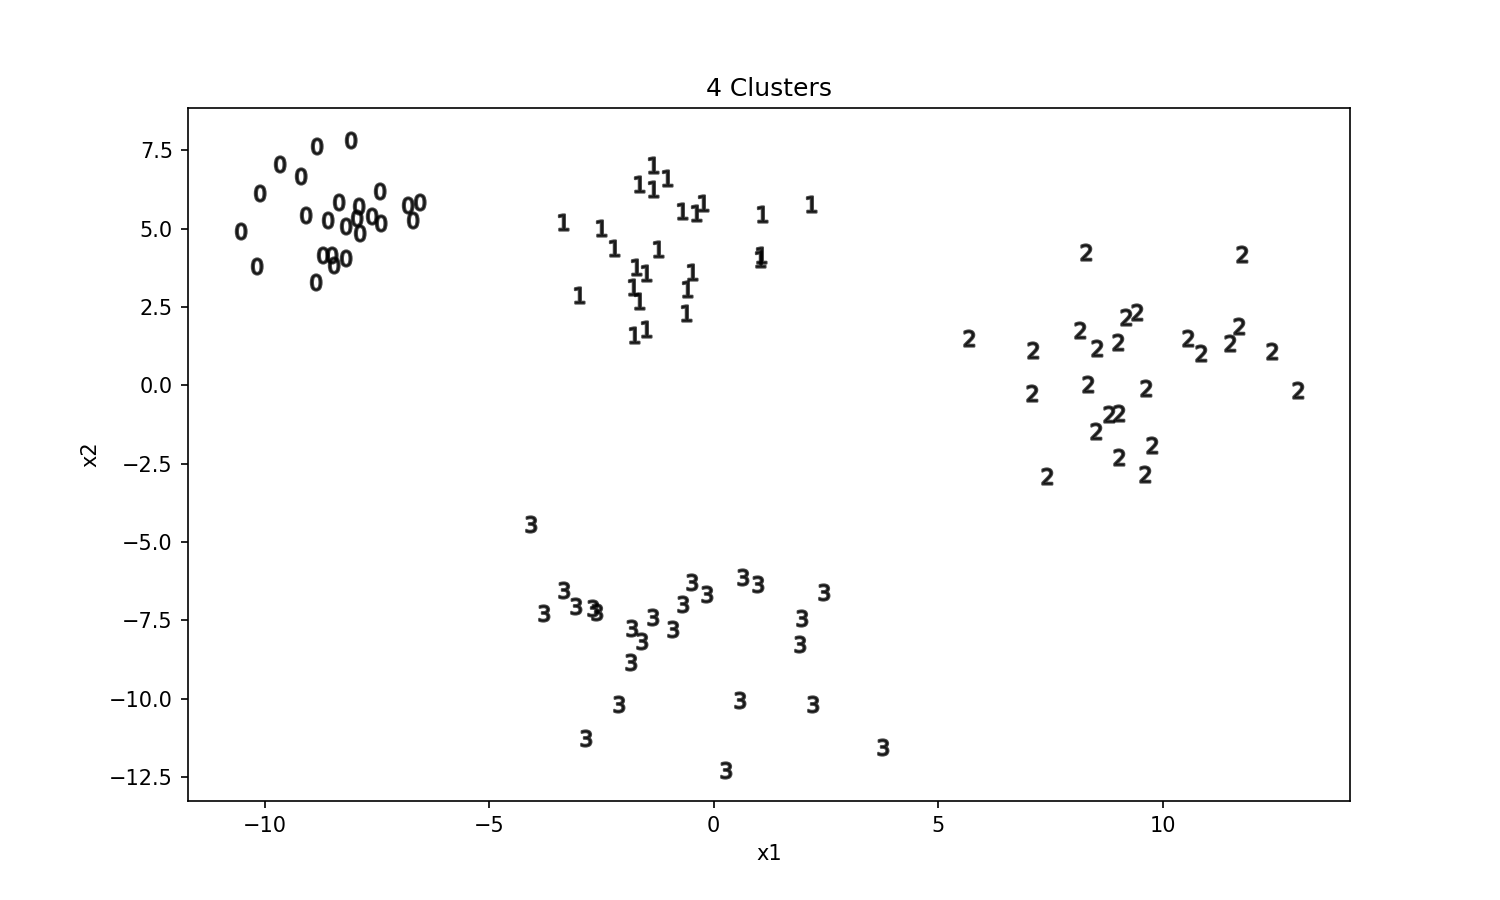

In [6]:
# 数据真实分布图：
fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharey=False)

x, y = df_blobs[['x1', 'x2']], df_blobs['y']
plot_2d_clusters(x, y, ax)

# K-Means

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=7)

x, y = df_blobs[['x1', 'x2']], df_blobs['y']
y_pred = kmeans.fit_predict(x)

<IPython.core.display.Javascript object>


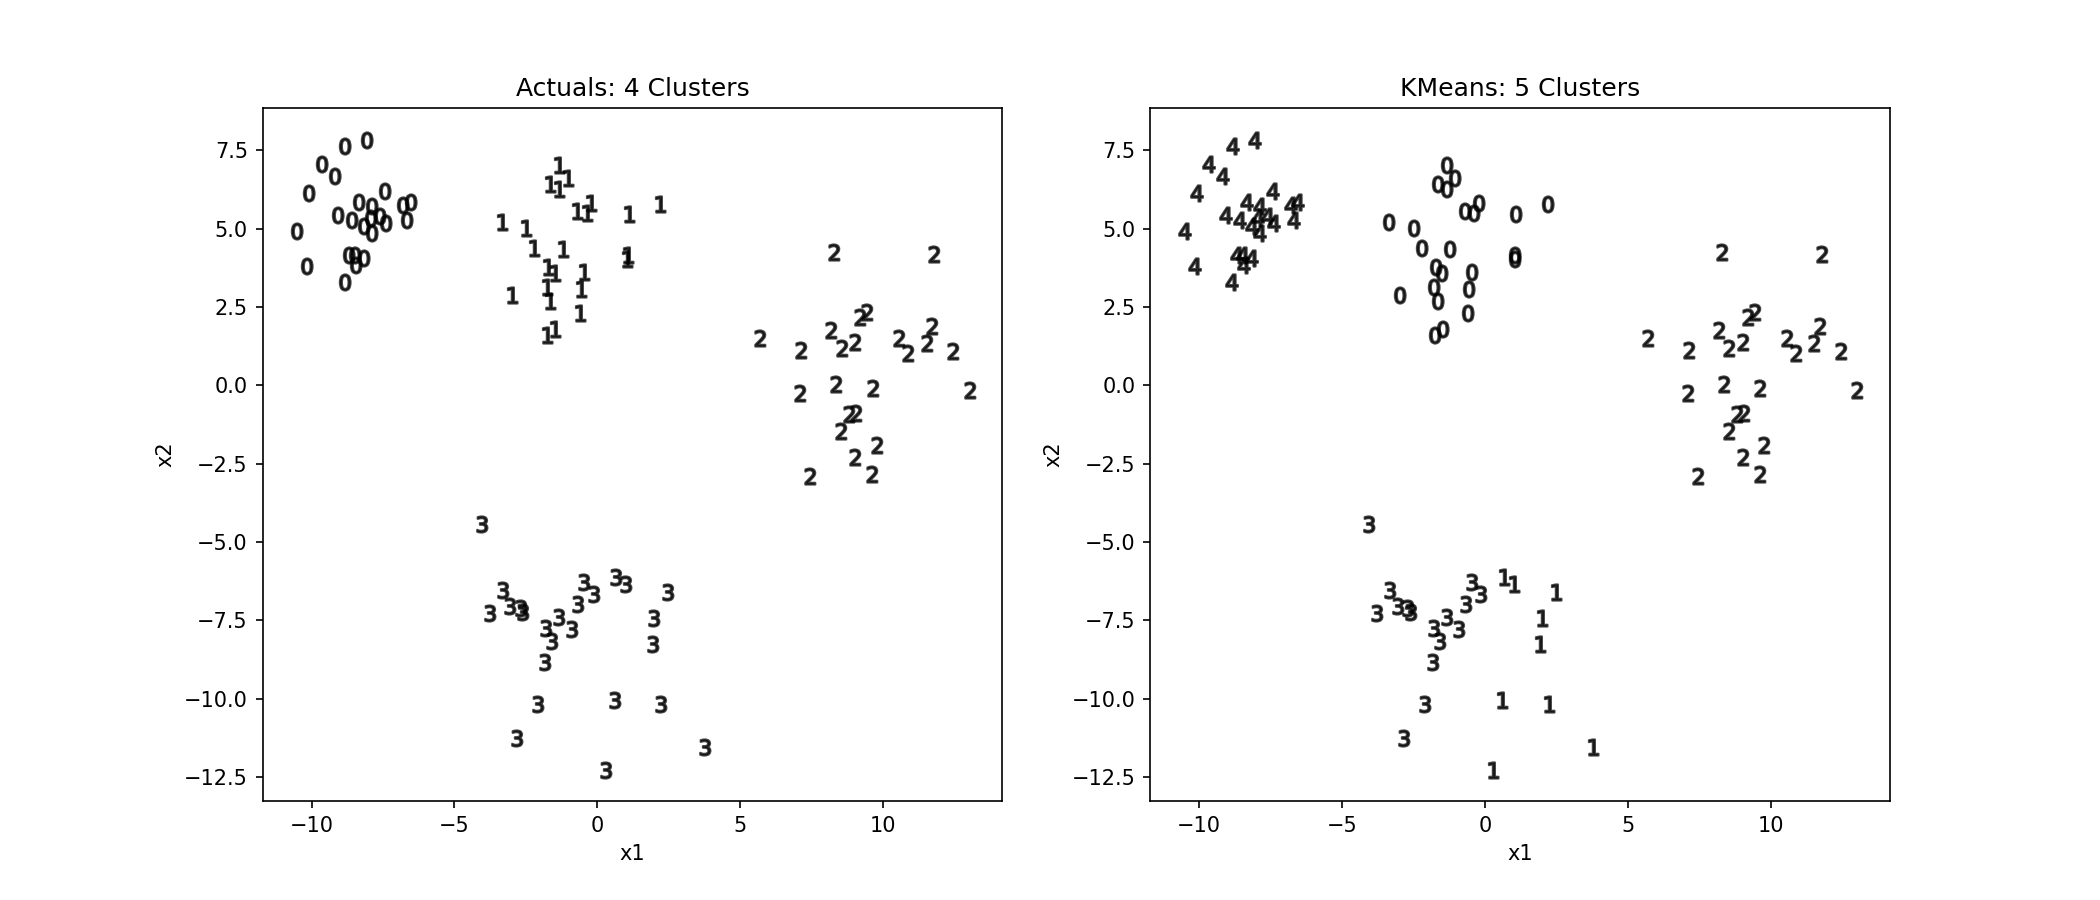

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

x, y = df_blobs[['x1', 'x2']], df_blobs['y']
plot_2d_clusters(x, y, axs[0])
plot_2d_clusters(x, y_pred, axs[1])

axs[0].set_title(f'Actuals: {axs[0].get_title()}')
axs[1].set_title(f'KMeans: {axs[1].get_title()}')
print('')

## 如何确定K值?

<IPython.core.display.Javascript object>


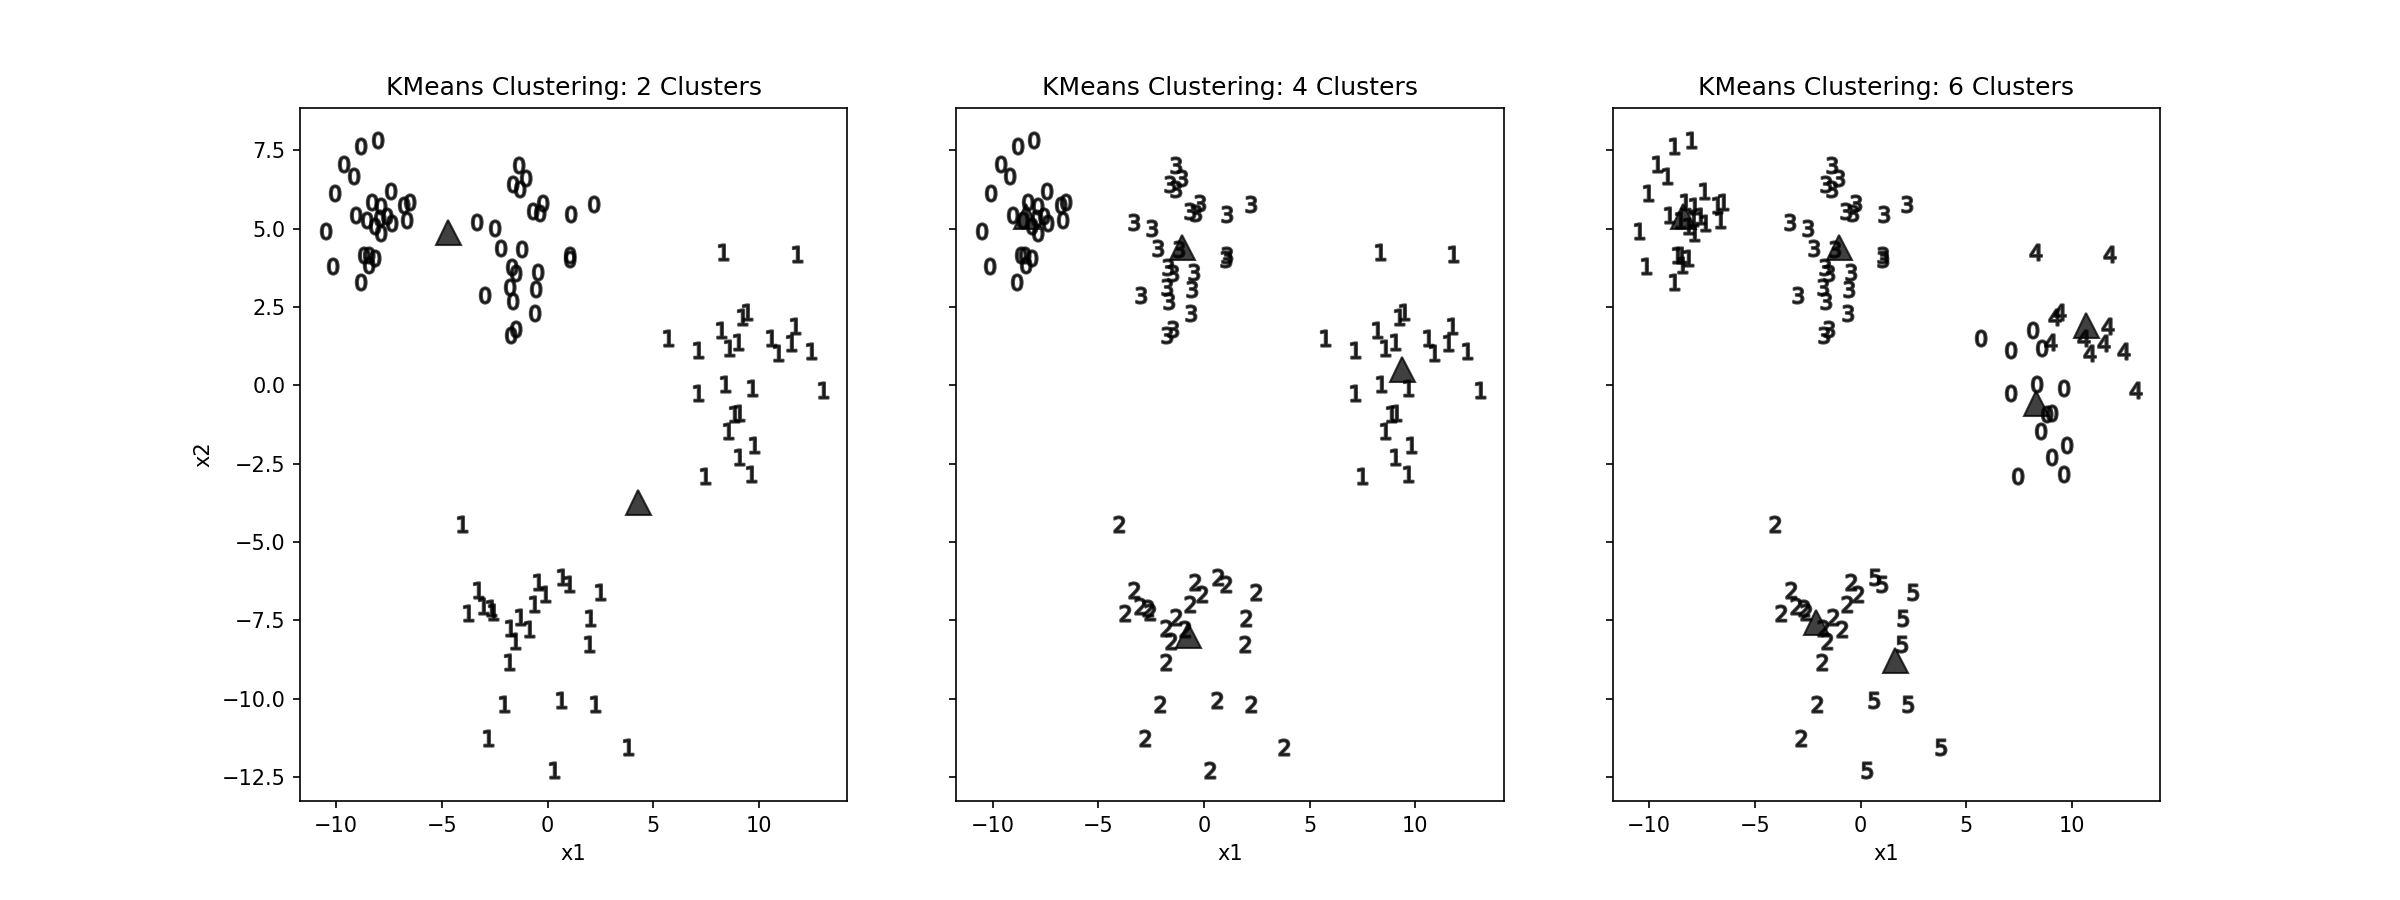

In [9]:
from sklearn.cluster import KMeans

# 分别尝试聚类簇个数为[2,4,6]的数据表现
n_clusters_options = [2, 4, 6]

fig, axs = plt.subplots(1, len(n_clusters_options), figsize=(16, 6), sharex=True, sharey=True)

for i, n_clusters in enumerate(n_clusters_options):
    
    x, y = df_blobs[['x1', 'x2']], df_blobs['y']

    kmeans = KMeans(n_clusters=n_clusters, random_state=7)
    y_pred = kmeans.fit_predict(x)
    
    plot_2d_clusters(x, y_pred, axs[i])
    
    axs[i].plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 'k^', ms=12, alpha=0.75)
    axs[i].set_title(f'KMeans Clustering: {axs[i].get_title()}')

## Silhouette Score 轮廓系数

衡量聚类簇个数是否合适，轮廓系数取值为[-1, 1]，其值越大越好，且当值为负时，样本被分配到错误的簇中，聚类结果不可接受。对于接近0的结果，则表明聚类结果有重叠的情况。

Advantages:
- The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
- The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

Drawbacks:
- The Silhouette Coefficient is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

Source: [Scikit-Learn User Guide](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

In [10]:
# 计算不同k值时，算法的轮廓系数，选择使轮廓系数最大的k值

from sklearn.metrics import silhouette_score

n_clusters_options = [2, 3, 4, 5, 6, 7, 8]
silhouette_scores = []

for i, n_clusters in enumerate(n_clusters_options):

    x, y = df_blobs[['x1', 'x2']], df_blobs['y']
    kmeans = KMeans(n_clusters=n_clusters, random_state=7)
    y_pred = kmeans.fit_predict(x)

    silhouette_scores.append(silhouette_score(x, y_pred))

<IPython.core.display.Javascript object>


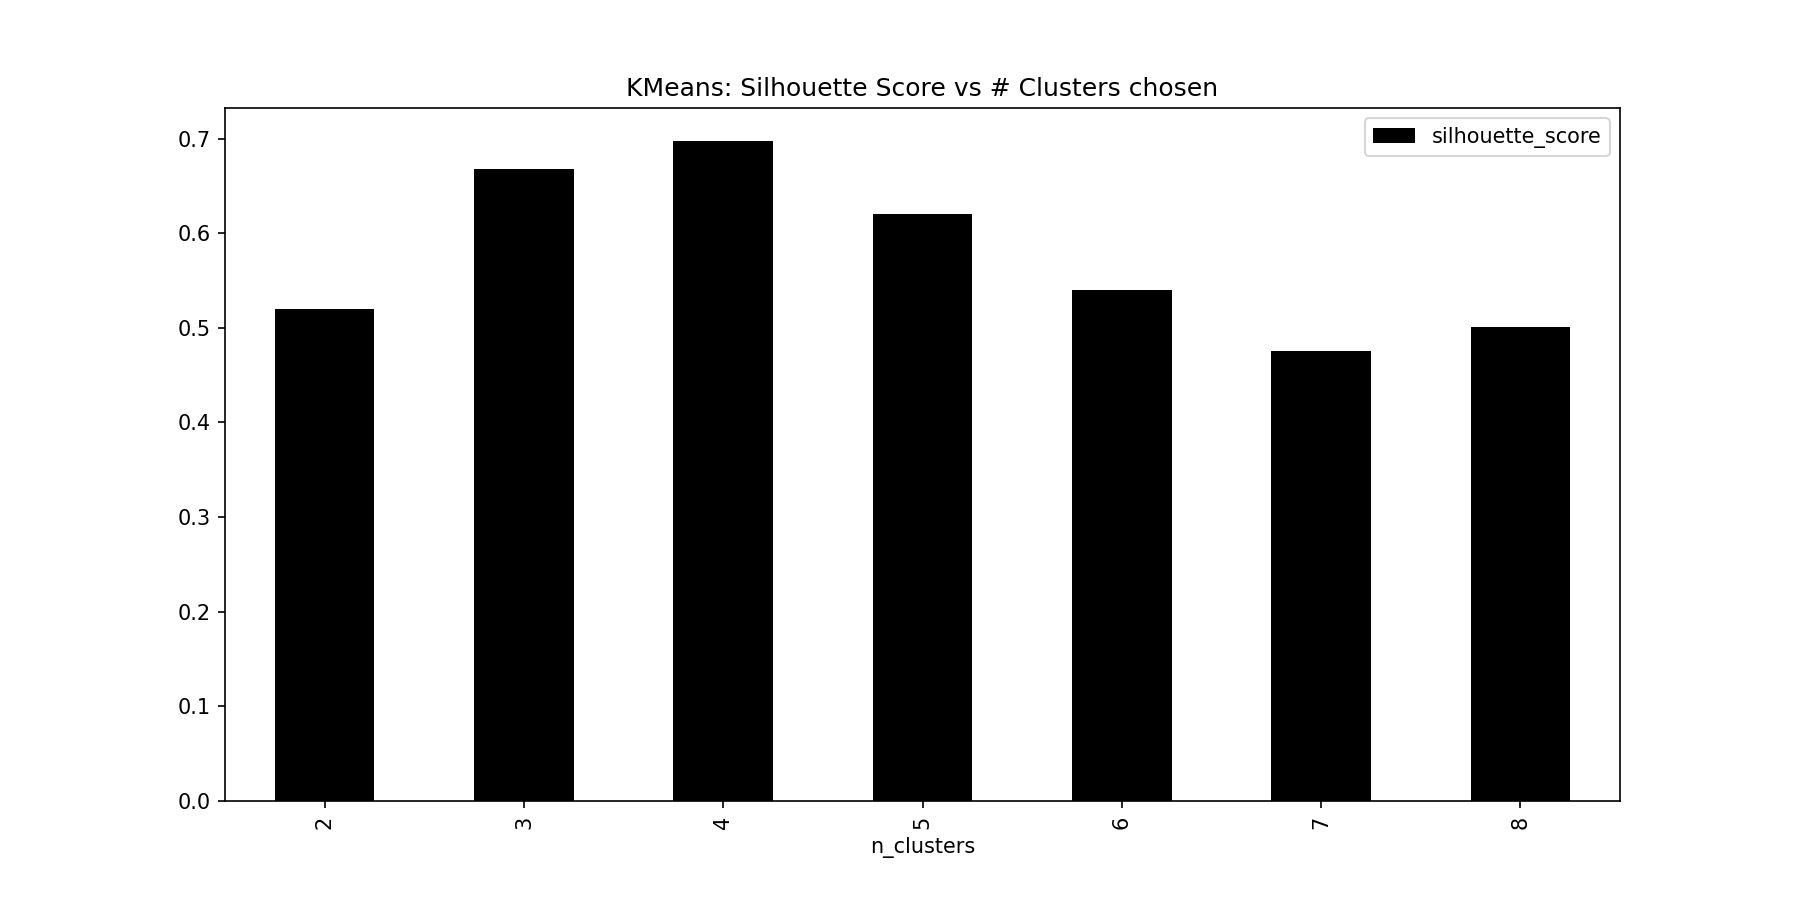

In [11]:
# 作图设定
fig, ax = plt.subplots(1, 1, figsize=(12, 6), sharey=False)

pd.DataFrame(
    {
        'n_clusters': n_clusters_options,
        'silhouette_score': silhouette_scores,
    }
).set_index('n_clusters').plot(
    title='KMeans: Silhouette Score vs # Clusters chosen',
    kind='bar',
    color='k',
    ax=ax
)

print('')

## 初始化质心位置对k-means影响

<IPython.core.display.Javascript object>


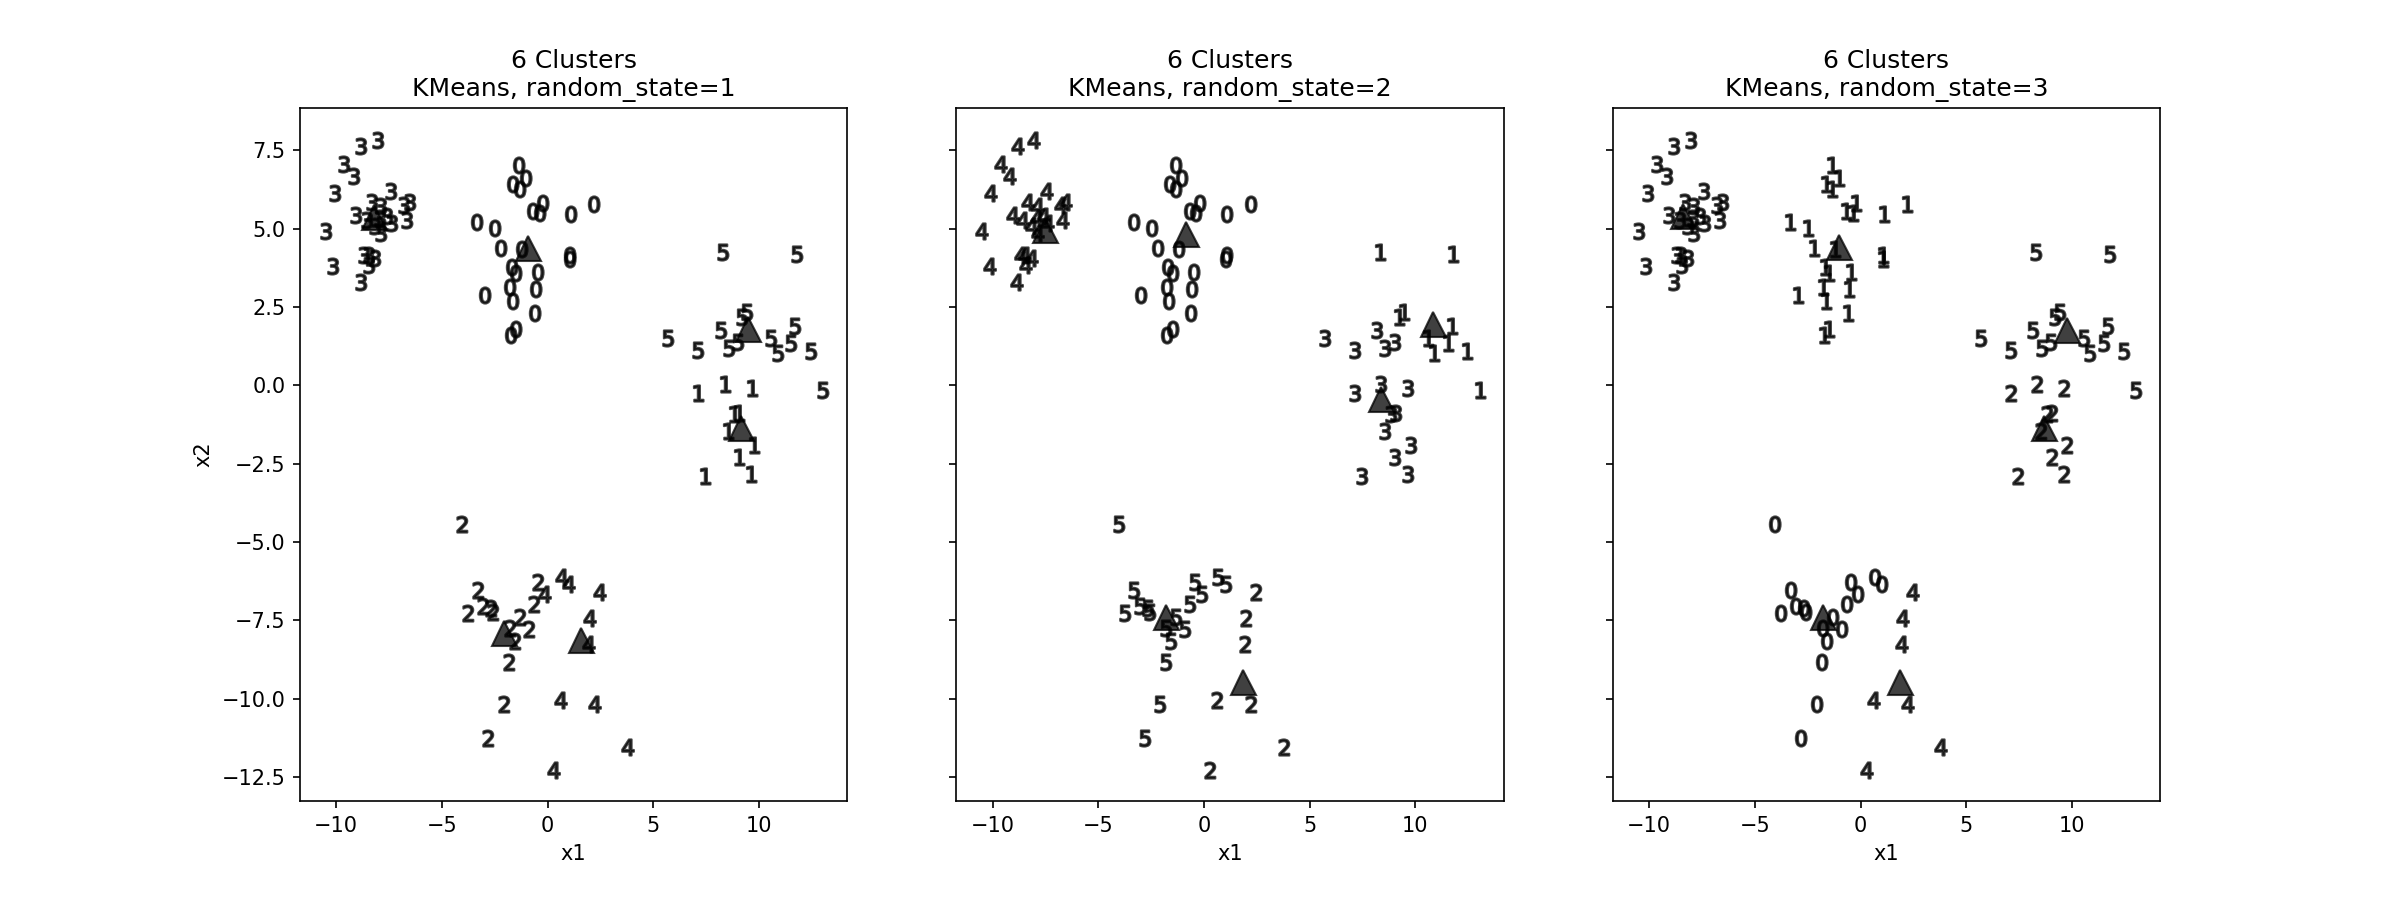

In [12]:
from sklearn.cluster import KMeans

random_state_options = [1, 2, 3]

fig, axs = plt.subplots(1, len(random_state_options), figsize=(16, 6), sharex=True, sharey=True)

for i, random_state in enumerate(random_state_options):
    
    x, y = df_blobs[['x1', 'x2']], df_blobs['y']
    kmeans = KMeans(init='random', max_iter=2, n_clusters=6, random_state=random_state)
    y_pred = kmeans.fit_predict(x)
    
    plot_2d_clusters(x, y_pred, axs[i])
    
    axs[i].plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 'k^', ms=12, alpha=0.75)
    
    axs[i].set_title(f'{axs[i].get_title()}\nKMeans, random_state={random_state}')

## k-means难以处理的数据

In [13]:
from sklearn.datasets import make_moons
# noisy_moons: 数据点构成两个交错的半圆。
x, y = make_moons(n_samples=120, noise=0.08, random_state=7)

df_moons = pd.DataFrame(
    {
        'x1': x[:,0],
        'x2': x[:,1],
        'y': y
    }
)

<IPython.core.display.Javascript object>


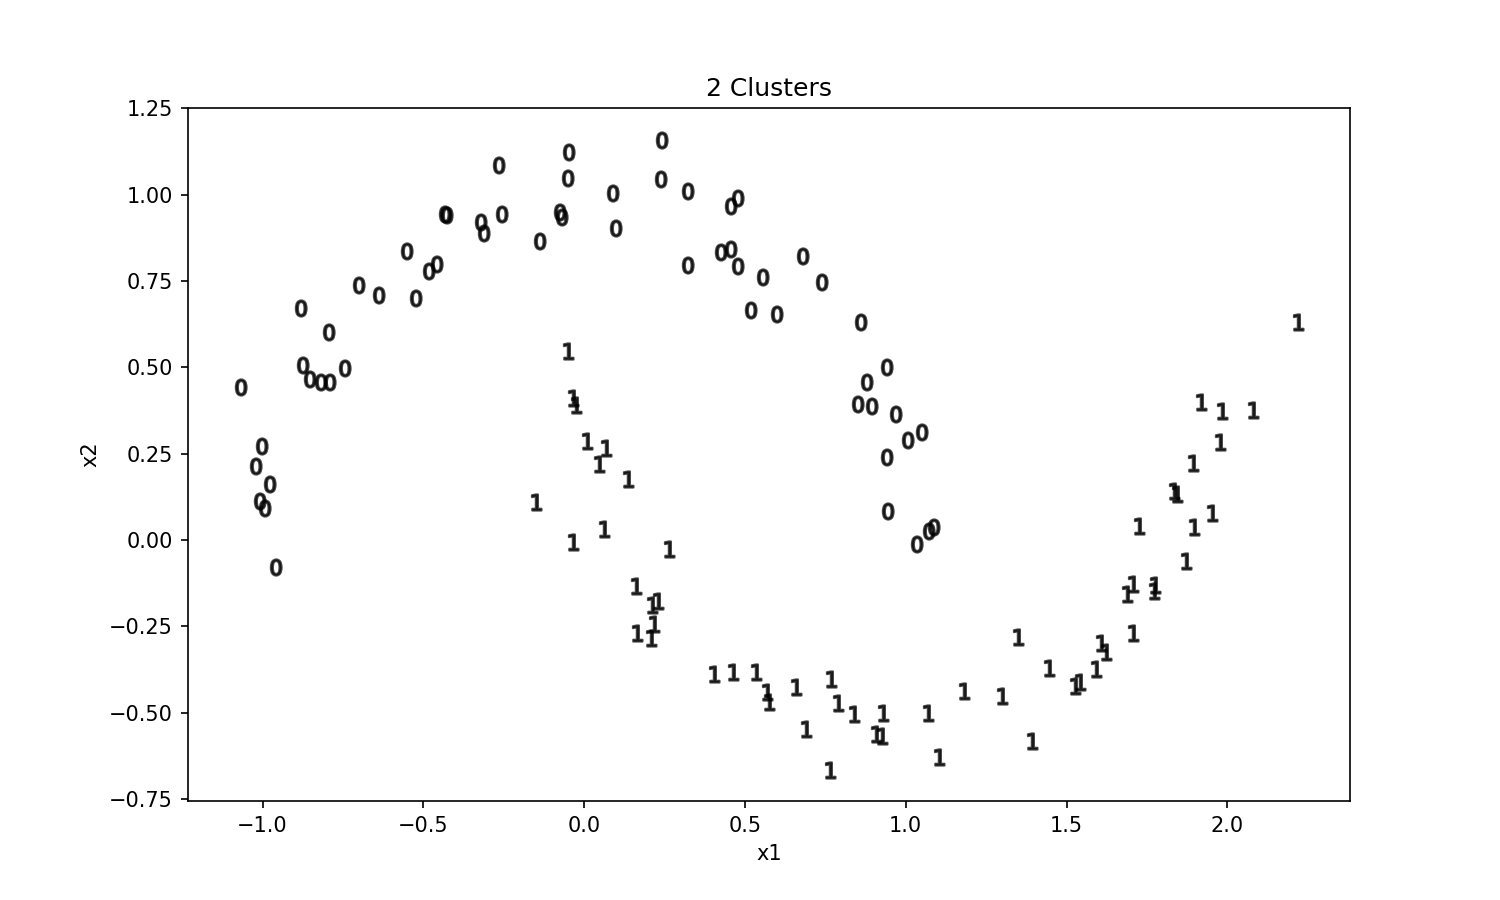

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharey=False)

x, y = df_moons[['x1', 'x2']], df_moons['y']
plot_2d_clusters(x, y, ax)

In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=7)

x, y = df_moons[['x1', 'x2']], df_blobs['y']
y_pred = kmeans.fit_predict(x)

<IPython.core.display.Javascript object>


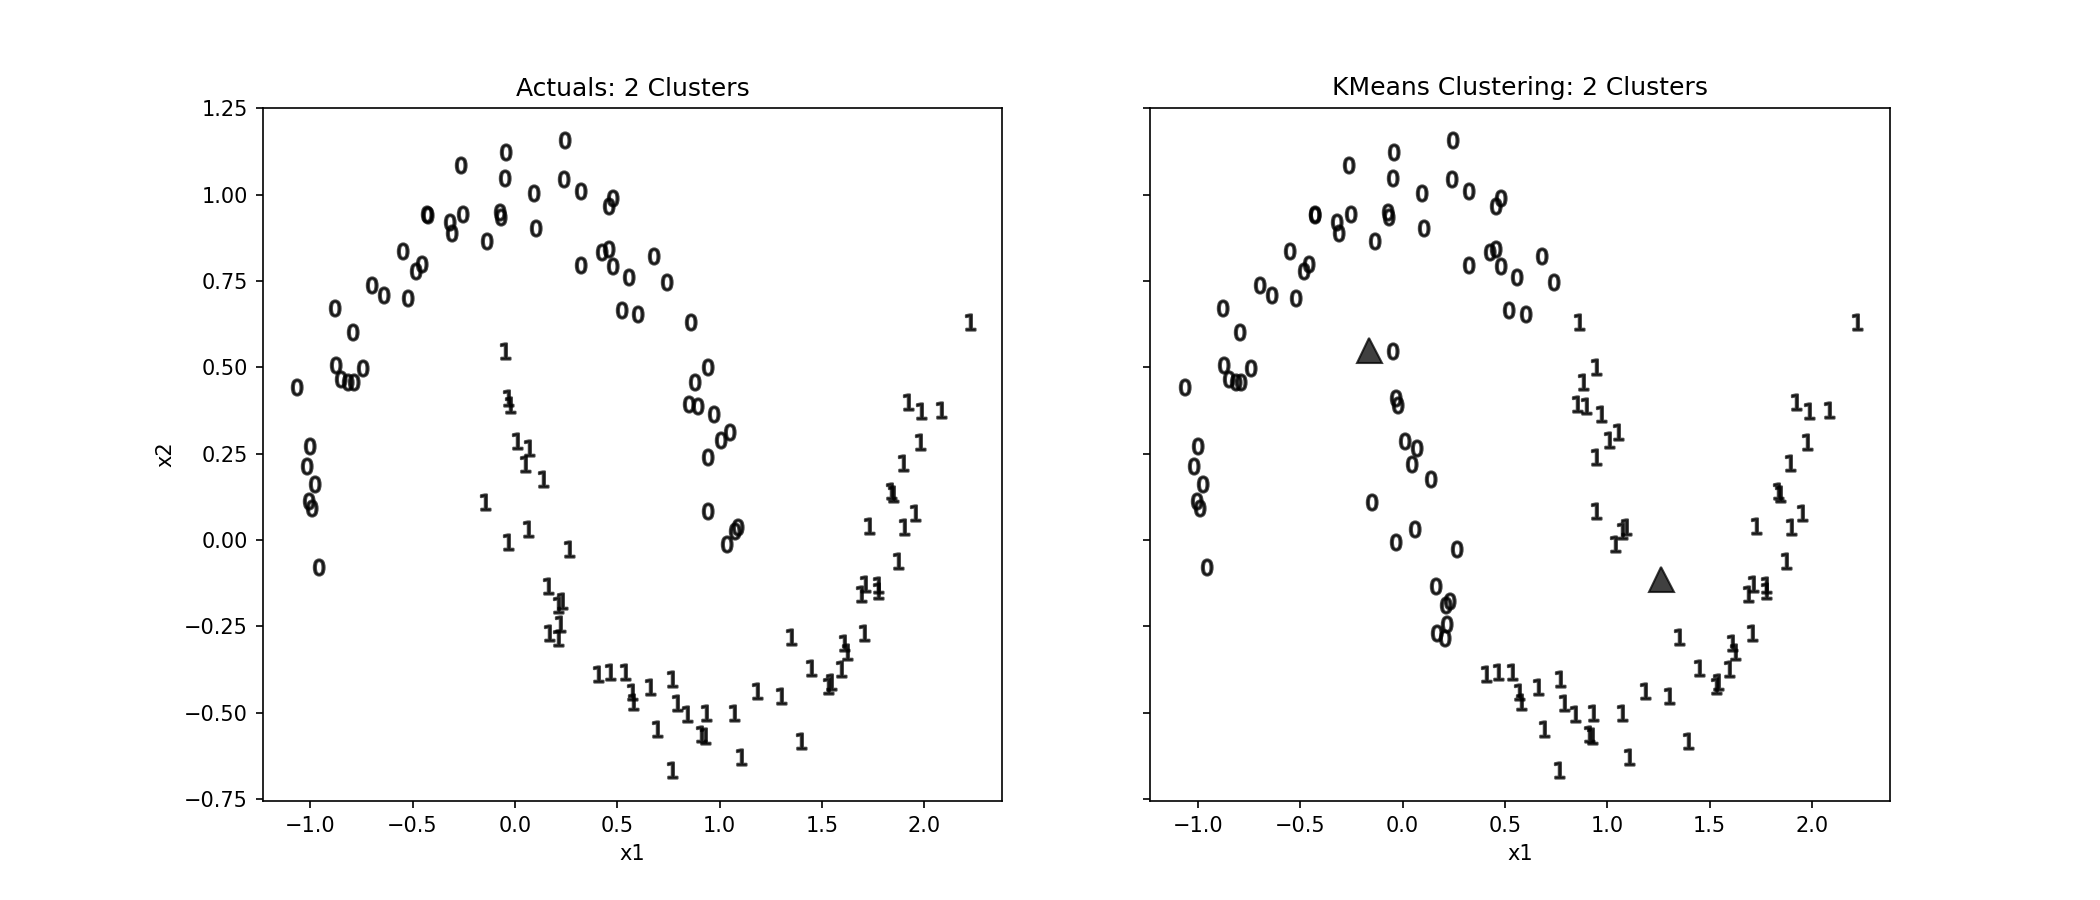

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

x, y = df_moons[['x1', 'x2']], df_moons['y']
plot_2d_clusters(x, y, axs[0])
plot_2d_clusters(x, y_pred, axs[1])

axs[0].set_title(f'Actuals: {axs[0].get_title()}')
axs[1].set_title(f'KMeans Clustering: {axs[1].get_title()}')

axs[1].plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 'k^', ms=12, alpha=0.75)

print('')

## 数据不均衡问题

In [17]:
from sklearn.datasets import make_blobs

#指定不同的n_samples构造不均衡数据
x, y = make_blobs(n_samples=[400, 20], cluster_std=[1.3, 1.2], n_features=2, random_state=7)

df_imbalanced_blobs = pd.DataFrame(
    {
        'x1': x[:,0],
        'x2': x[:,1],
        'y': y
    }
)

<IPython.core.display.Javascript object>


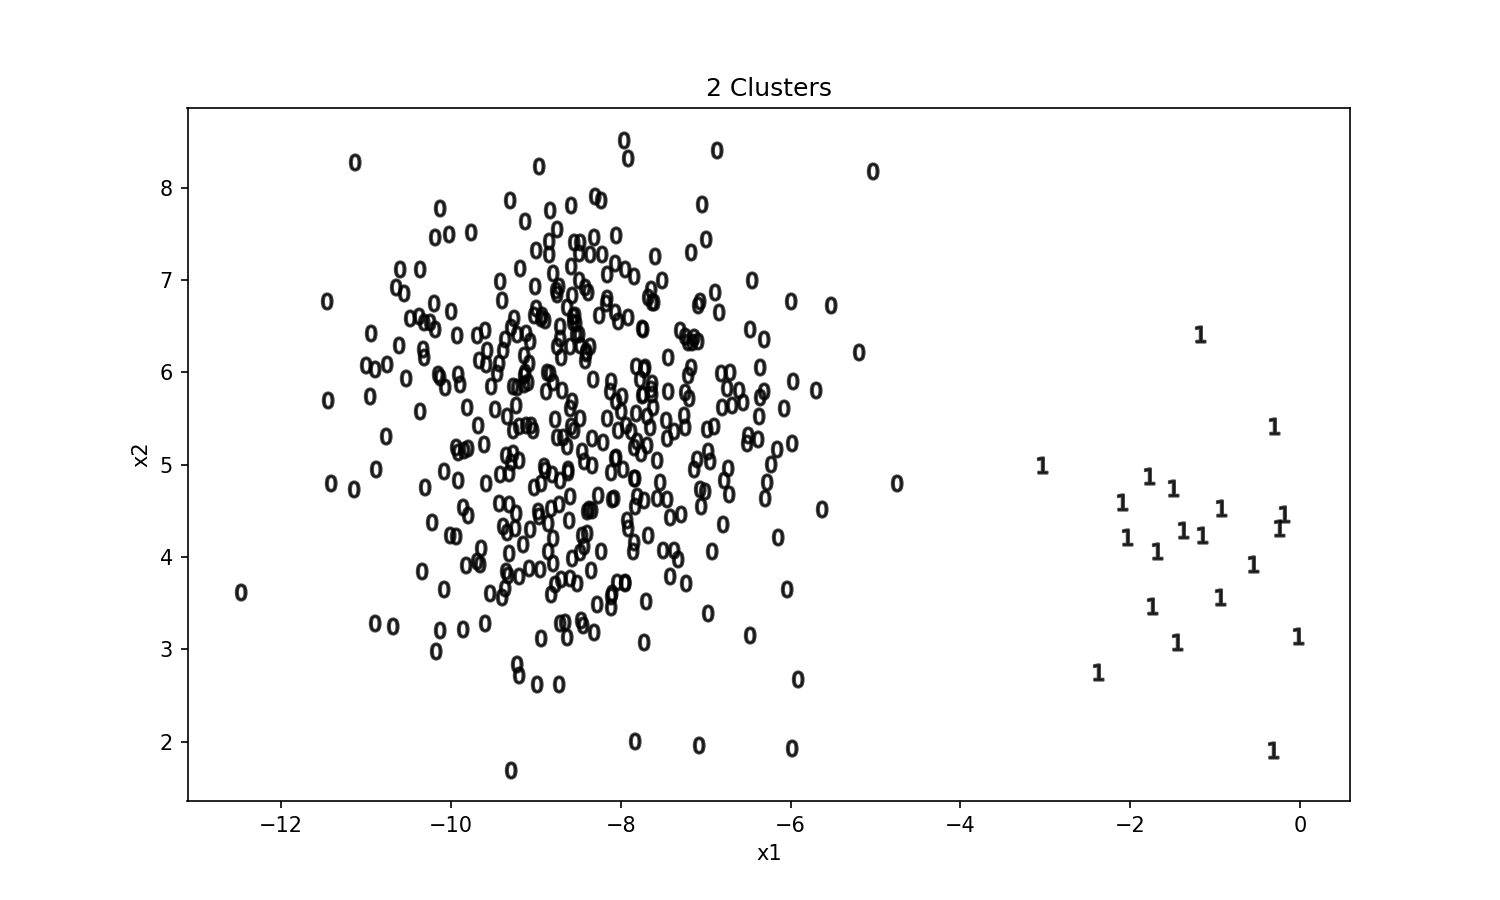

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharey=False)

x, y = df_imbalanced_blobs[['x1', 'x2']], df_imbalanced_blobs['y']
plot_2d_clusters(x, y, ax)

In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=7)

x, y = df_imbalanced_blobs[['x1', 'x2']], df_imbalanced_blobs['y']
y_pred = kmeans.fit_predict(x)

<IPython.core.display.Javascript object>


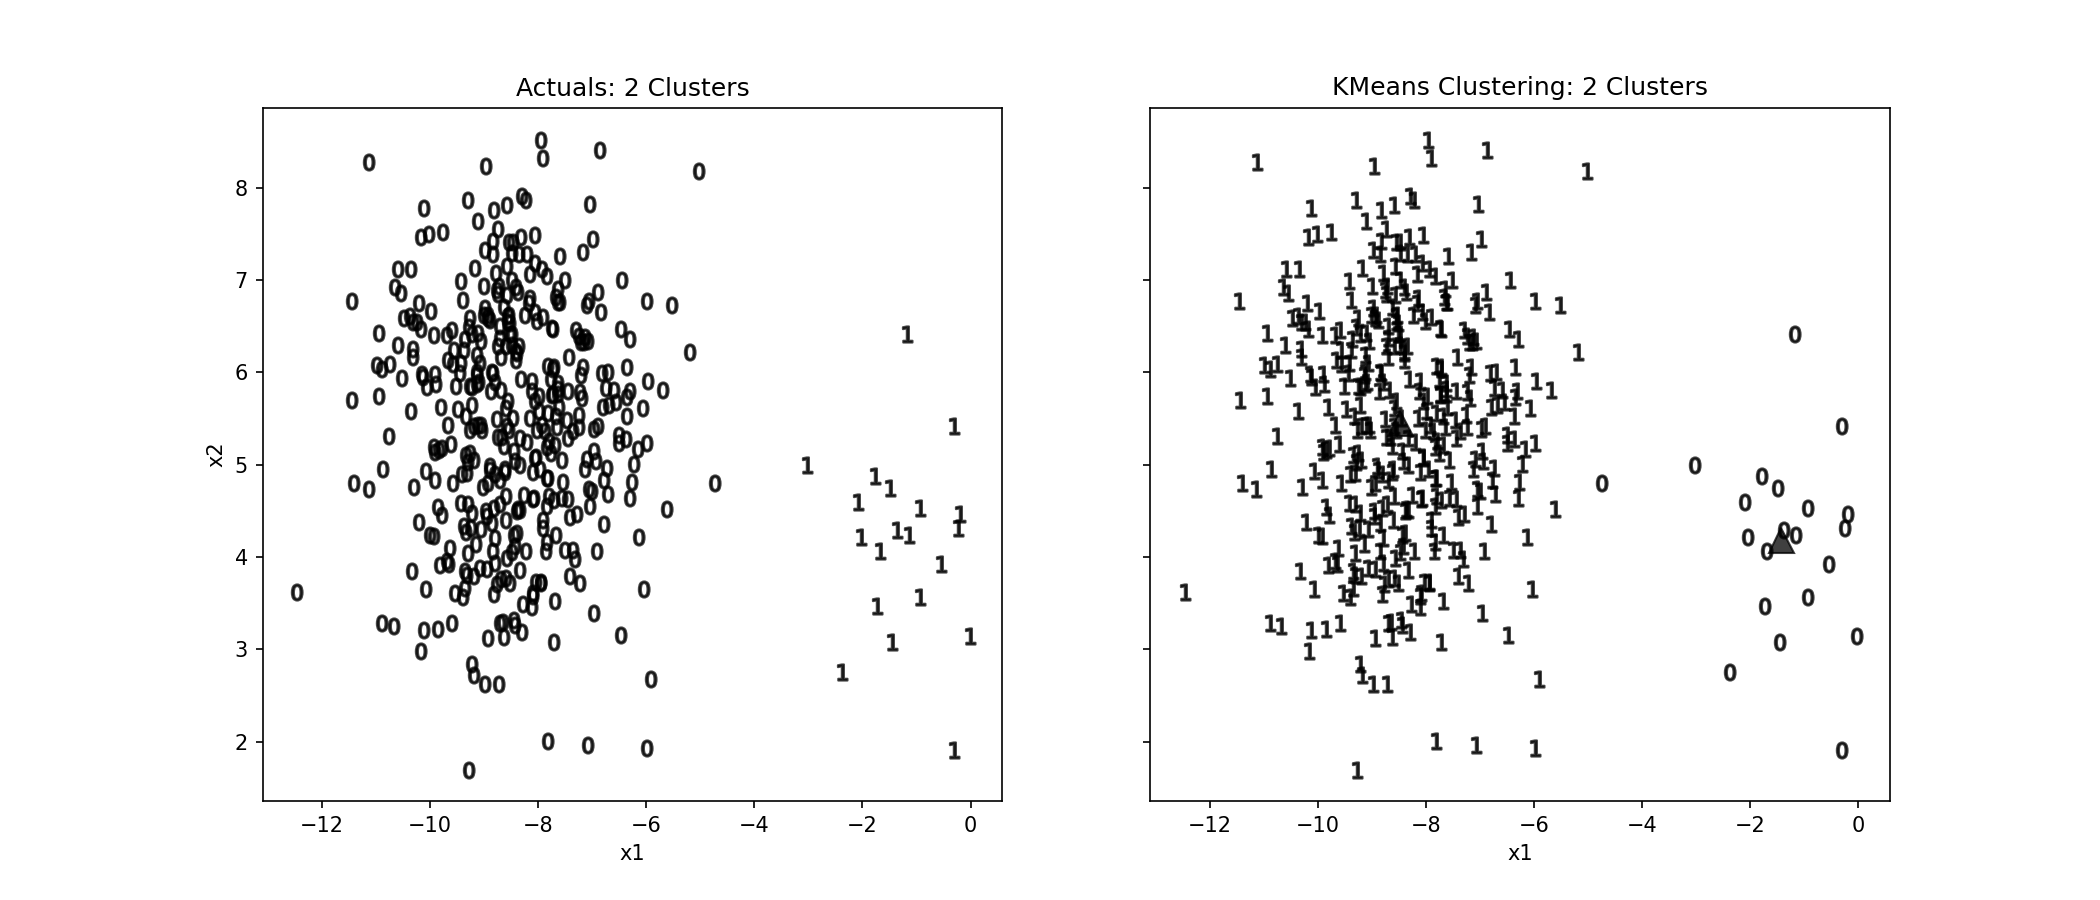

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

x, y = df_imbalanced_blobs[['x1', 'x2']], df_imbalanced_blobs['y']

plot_2d_clusters(x, y, axs[0])
plot_2d_clusters(x, y_pred, axs[1])

axs[0].set_title(f'Actuals: {axs[0].get_title()}')
axs[1].set_title(f'KMeans Clustering: {axs[1].get_title()}')

axs[1].plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 'k^', ms=12, alpha=0.75)

print('')